# Bases de données et création de procédés

Nous avons vu qu'une ACV consistait en deux grandes étapes : 
1. celle d'inventaire ;
2. puis celle de caractérisation d'inventaire.

En pratique, on s'appuie sur des bases de données (BDD) qui décrivent :
- la technosphère (ensemble des procédés et des flux qui les relient, dits flux intermédiaires) ; 
- la biosphère (ensemble des matières et substances potentiellement extraites ou émises par les procédés, dits flux élémentaires) ;
- les méthodes d'impacts (défintion des catégories d'impact, des indicateurs, des facteurs de caractérisation associés, et accessoirement des facteurs d'agrégation et/ou de normalisation)

SCHEMA INVENTAIRE IMPACTS FLUX

Commençons par les procédés. Nous utilisons couramment pour modéliser ces derniers la base de données ecoinvent qui est générique - elle recouvre plusieurs secteurs d'activités (Industrie, Énergie, Matériaux, Transports...).

Vous pouvez explorer cette BDD en ligne à ce lien : [https://ecoquery.ecoinvent.org/3.11/cutoff](https://ecoquery.ecoinvent.org/3.11/cutoff). (version, allocation, exemple de procédé)

Pour réaliser des ACV à partir de ces BDD, plusieurs logiciels sont disponibles (des libres tels OpenLCA et brightway ; des payants tels SimaPro, OneClick LCA ou Holis). Nous utilisons la librairie python brightway 2.5 dans ce qui suit car elle est open-source, permet de profiter de l'écosystème python, s'appuie explicitement sur le formalisme mathématique vu précédemment et évite l'effet "boîte noire".

**Documentation de brightway2.5**

Voir :

- documentation générale : https://docs.brightway.dev/en/latest/content/overview/index.html
- pense-bête : https://docs.brightway.dev/en/latest/content/cheatsheet/index.html

## Import des librairies et mise en place du projet

In [2]:
import bw2io as bi # ensemble des fonctions et classes pour importer et exporter (input/output)
import bw2data as bd # ... pour gérer les données du projet
import bw2calc as bc # ... pour faire des opérations
import bw2analyzer as ba # ... pour interpréter les résultats

In [4]:
bd.projects.set_current('2025-06-10_ecoinvent_311') # On se met dans un projet (ie un dossier) qui contient déjà ecoinvent 3.11 cut-off

In [6]:
bd.databases # On peut vérifier les BDD disponibles dans ce projet

Databases dictionary with 3 object(s):
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-cutoff
	soletanche_database

## Exploration d'ecoinvent

On peut commencer par se poser les questions suivantes.

1. Combien y a-t-il d'éléments dans cette biosphère ?

In [ ]:
biodb = bd.Database('ecoinvent-3.11-biosphere')
len(biodb)

9795

In [ ]:
element = biodb.random() #On met dans une variable un élément de la biosphère choisi aléatoirement 
element

'Propisochlor' (kilogram, None, ('air', 'non-urban air or from high stacks'))

In [ ]:
element.as_dict()

{'categories': ('air', 'non-urban air or from high stacks'),
 'code': '076fb2c0-6583-59d2-a74b-6f894c48c75e',
 'CAS number': '086763-47-5',
 'synonyms': [],
 'name': 'Propisochlor',
 'database': 'ecoinvent-3.11-biosphere',
 'unit': 'kilogram',
 'type': 'emission',
 'id': 190810763284049932}

2. Combien y a-t-il de procédés dans cette technosphère ?

In [12]:
eidb = bd.Database('ecoinvent-3.11-cutoff') #On sélectionne la technosphere que l'on stocke dans une variable
len(eidb) #La longueur de celle-ci correspond au nombre de procédés différents disponibles

25412

In [30]:
activity = eidb.random()
activity

'market for natural gas, high pressure' (cubic meter, BO, None)

In [31]:
activity.as_dict()

{'comment': 'This is a market activity. Each market represents the consumption mix of a product in a given geography, connecting suppliers with consumers of the same product in the same geographical area. Markets group the producers and the imports of the product (if relevant) within the same geographical area. They also account for transport (distribution) to the consumer and for the losses during that process, when relevant.\nThis is the market for ‘natural gas, high pressure\' [m3], in the geography of Bolivia. The consumption mix is calculated based on own production - if relevant - and trade statistics for 2023 from Energy Institute (2024). It contains information on energy and transport requirement (excluding for any imports, which are modelled in separate datasets) and the losses and emissions occurring during the distribution. This information has been extrapolated from other geographies, based on modelling described in Bussa et al. (2024).\nThe product ‘natural gas, high press

3. Comment un procédé est-il relié aux autres ?

In [ ]:
activity = eidb.search('anchovy') #On utilise une fonction de recherche par mot-clé, ici "anchovy"
activity # brightway retourne une liste de procédés

['landed anchovy by-catch, fresh to generic market for marine fish' (kilogram, GLO, None),
 'landed anchovy to generic market for marine fish' (kilogram, GLO, None),
 'market for landed anchovy, fresh' (kilogram, PE, None),
 'market for landed anchovy, fresh' (kilogram, RoW, None),
 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None),
 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None),
 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, RoW, None),
 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, RoW, None),
 'market for landed anchovy by-catch, fresh' (kilogram, GLO, None),
 'fishmeal and fish oil production, 63-65% protein, from fresh anchovy' (kilogram, RoW, None),
 'fishmeal and fish oil production, 63-65% protein, from fresh anchovy' (kilogram, PE, None),
 'market for fish oil, from anchovy' (kilogram, GLO, None),
 'anchovy, capture by steel purse seiner a

In [41]:
activity = eidb.search('anchovy, capture by steel purse seiner')[0] #On choisit le premier élément de la liste, en précisant le mot-clé
activity #Ici, activity sera bien un procédé, non une liste de procédés

'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None)

On regarde maintenant quels sont ses échanges avec la technosphère et la biosphère.

In [ ]:
list(activity.exchanges()) #Tous les échanges

[Exchange: 1.0 kilogram 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None) to 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None)>,
 Exchange: -0.002032598343604353 kilogram 'market for antifouling paint emissions' (kilogram, GLO, None) to 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None)>,
 Exchange: 17.88461398791684 megajoule 'market for diesel, burned in fishing vessel' (megajoule, GLO, None) to 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None)>,
 Exchange: 0.006310948398860212 kilogram 'market for lubricating oil' (kilogram, RER, None) to 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None)>,
 Exchange: 0.47813383803583204 kilogram day 'market for operation, reefer, freezing' (kilogram day, GLO, None) to 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None)>,
 Exchange: 0.

In [44]:
list(activity.technosphere()) #Flux intermédiaires

[Exchange: -0.002032598343604353 kilogram 'market for antifouling paint emissions' (kilogram, GLO, None) to 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None)>,
 Exchange: 17.88461398791684 megajoule 'market for diesel, burned in fishing vessel' (megajoule, GLO, None) to 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None)>,
 Exchange: 0.006310948398860212 kilogram 'market for lubricating oil' (kilogram, RER, None) to 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None)>,
 Exchange: 0.47813383803583204 kilogram day 'market for operation, reefer, freezing' (kilogram day, GLO, None) to 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None)>,
 Exchange: 0.01301350223451024 kilogram 'market for purse seiner maintenance, steel' (kilogram, GLO, None) to 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None)>,
 Exchange: 0.0130

In [ ]:
list(activity.biosphere()) #Flux élémentaires

[Exchange: 0.0943237168289159 kilogram 'Discarded fish, pelagic, to ocean' (kilogram, None, ('water', 'ocean')) to 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None)>,
 Exchange: 1.3262161254194131 kilogram 'Fish, pelagic, in ocean' (kilogram, None, ('natural resource', 'biotic')) to 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None)>]

In [48]:
list(activity.production()) #Flux de référence (produit)

[Exchange: 1.0 kilogram 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None) to 'anchovy, capture by steel purse seiner and landing whole, fresh' (kilogram, ES, None)>]

N'oubliez pas la page pense-bête de brightway : https://docs.brightway.dev/en/latest/content/cheatsheet/inventory.html

Pour les personnes souhaitant en savoir plus sur la structure en graphe des données dans brightway : https://docs.brightway.dev/en/latest/content/overview/inventory.html 

Bien que nous adorions la tapenade, nous allons commencer par modéliser ce que tout élève des Ponts préfère : le BÉTON ARMÉ.

## Construction de procédés béton

Il en existe dans la base de données :

In [66]:
concrete = ...

Existe-t-il des procédés modélisant des bétons spécifiquement français ?

Nous utilisons une compréhension de liste conditionnelle pour préciser la recherche :

In [67]:
concrete = [a for a in eidb if 'concrete' in a['name'].lower() and a['location'] == 'FR']
concrete

[]

Comme il n'y en a pas, nous allons modéliser deux formulations avec les données dont nous disposons, pour les comparer. On en profite pour prendre en compte des armatures (on étudie du béton armé) et de l'énergie (malaxage du béton).

Considérons les formulations suivantes pour 1 m3 de béton : 

- 350kg de ciment Portland (béton A) ou CEM III/B (béton B)
- 175kg d'eau
- 800kg de sable
- 1100kg de gravier

Pour le ferraillage, prenons un ratio de 100 kg d'acier par m3 de béton. Avez-vous une remarque ?

Pour l'énergie de malaxage, prenons l'hypothèse de 14.4 MJ par m3 de béton.

Les procédés mobilisés sont les suivants :

Béton | Flux | Procédé choisi dans ecoinvent | Région | Unité | Qté pour 1m3
:---: | :---: | :---: | :---: | :---: | :---:
Béton A | ciment Portland | market for cement, Portland | Europe without Switzerland | kg | 350
Béton B | CEM III/B | market for cement, CEM III/B | Europe without Switzerland | kg | 350
Béton A & B | eau | market for tap water | Europe without Switzerland | kg | 175
Béton A & B | sable | market for sand | Rest-of-World (RoW) | kg | 800 
Béton A & B | graviers | market for gravel, crushed | Rest-of-World (RoW) | kg | 1100
Béton A & B | ferraillage | market for reinforcing steel | Global | kg | 100
Béton A & B | énergie | diesel, burned in building machine | Global | MJ | 14.4

In [75]:
if 'betons_armes' in bd.databases : 
    print('procédés déjà importés !')
else : 
    imp = bi.ExcelImporter("/home/thibault.chevilliet@enpc.fr/Documents/Cours ACV notebook/Cours 2025/betons_armes.xlsx")
    imp.apply_strategies() #applique une série de routines sur la base de données, notamment une conversion des variables dans les bons formats
    imp.match_database(fields=('name', 'unit', 'location')) #identifie les échanges que les procédés de la base ont avec d'autres procédés de la même base
    imp.match_database('ecoinvent-3.11-cutoff', fields=('name', 'unit', 'location')) #identifie les échanges que les procédés de la base ont avec les procédés d'ecoinvent
    imp.statistics() #affiche les statistiques des "match" réalisés, notamment si certains procédés n'ont pas été trouvés ("unlinked exchanges") 
    imp.write_database() #écrit et sauvegarde la base de données

Extracted 1 worksheets in 0.02 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.29 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Graph statistics for `betons_armes` importer:
2 graph nodes:
	process: 2
14 graph edges

100%|██████████| 2/2 [00:00<00:00, 2585.88it/s]

15:54:12 [info     ] Vacuuming database            


Created database: betons_armes


In [76]:
fgdb = bd.Database('betons_armes') #fgdb pour foreground database

In [77]:
beton_A = fgdb.search('Béton A')[0]
beton_A

'Béton A' (cubic meter, FR, ('custom',))

In [78]:
list(beton_A.edges())

[Exchange: 1 cubic meter 'Béton A' (cubic meter, FR, ('custom',)) to 'Béton A' (cubic meter, FR, ('custom',))>,
 Exchange: 350 kilogram 'market for cement, Portland' (kilogram, Europe without Switzerland, None) to 'Béton A' (cubic meter, FR, ('custom',))>,
 Exchange: 175 kilogram 'market for tap water' (kilogram, Europe without Switzerland, None) to 'Béton A' (cubic meter, FR, ('custom',))>,
 Exchange: 800 kilogram 'market for sand' (kilogram, RoW, None) to 'Béton A' (cubic meter, FR, ('custom',))>,
 Exchange: 1100 kilogram 'market for gravel, crushed' (kilogram, RoW, None) to 'Béton A' (cubic meter, FR, ('custom',))>,
 Exchange: 100 kilogram 'market for reinforcing steel' (kilogram, GLO, None) to 'Béton A' (cubic meter, FR, ('custom',))>,
 Exchange: 14.4 megajoule 'diesel, burned in building machine' (megajoule, GLO, None) to 'Béton A' (cubic meter, FR, ('custom',))>]

## Calcul des impacts environnementaux

Pour calculer des impacts environnementaux, il faut savoir quoi calculer, c'est-à-dire choisir une méthode d'impact. 

Remarque sur le mot méthode :
- Traditionnellement, une méthode d'impact désigne un ensemble de catégories d'impacts, chaque catégorie contenant des indicateurs environnementaux et les facteurs de caractérisation permettant de calculer ces derniers à partir des flux élémentaires (en réalité, pour chaque indicateur, à partir d'un sous-ensemble de la biosphère).
- dans brightway, une "method" désigne en fait un indicateur spécifique (calculé selon une certaine méthode d'impact), ce qui peut prêter à confusion.


Pour ce TD, nous choisissons la méthode d'impacts Environmental Footprint v3.1.

In [96]:
meth = [m for m in bd.methods if 'EF v3.1' in m[1] and 'no LT' not in m[1]]
meth

[('ecoinvent-3.11', 'EF v3.1', 'acidification', 'accumulated exceedance (AE)'),
 ('ecoinvent-3.11',
  'EF v3.1',
  'climate change',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.11',
  'EF v3.1',
  'climate change: biogenic',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.11',
  'EF v3.1',
  'climate change: fossil',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.11',
  'EF v3.1',
  'climate change: land use and land use change',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.11',
  'EF v3.1',
  'ecotoxicity: freshwater',
  'comparative toxic unit for ecosystems (CTUe)'),
 ('ecoinvent-3.11',
  'EF v3.1',
  'ecotoxicity: freshwater, inorganics',
  'comparative toxic unit for ecosystems (CTUe)'),
 ('ecoinvent-3.11',
  'EF v3.1',
  'ecotoxicity: freshwater, organics',
  'comparative toxic unit for ecosystems (CTUe)'),
 ('ecoinvent-3.11',
  'EF v3.1',
  'energy resources: non-renewable',
  'abiotic depletion potential (ADP): fossil fuels'),
 ('ecoinvent-3.

### Calcul pour un indicateur et une demande

On s'intéresse dans un premier temps à l'impact sur le changement climatique en considérant le pouvoir de réchauffement global à 100 ans.

In [102]:
gwp100 = [ind for ind in meth if 'GWP100' in str(ind) and 'biogenic' not in str(ind) and 'fossil' not in str(ind) and 'land' not in str(ind)][0] # On sélectionne l'indicateur par compréhension de liste
gwp100

('ecoinvent-3.11',
 'EF v3.1',
 'climate change',
 'global warming potential (GWP100)')

In [103]:
lca = bc.LCA(demand={beton_A : 1.0},method=gwp100)
lca.lci()
lca.lcia()
lca.score

561.9650284777491

In [105]:
beton_B = fgdb.search('Béton B')[0]
beton_B

'Béton B' (cubic meter, FR, ('custom',))

In [106]:
lca = bc.LCA(demand={beton_B : 1.0},method=gwp100)
lca.lci()
lca.lcia()
lca.score

391.69460121070745

### Calcul pour plusieurs indicateurs et plusieurs demandes

In [114]:
demands = { 'A' : {beton_A.id : 1.0}, 'B' : {beton_B.id : 1.0}}

method_config = {'impact_categories' : meth}
data_objs = bd.get_multilca_data_objs(demands, method_config)

lca = bc.MultiLCA(demands=demands, method_config= method_config, data_objs=data_objs)
lca.lci()
lca.lcia()
results = lca.scores

In [119]:
import pandas as pd
df_results = pd.DataFrame.from_dict(results,orient='index')
df_results.columns

RangeIndex(start=0, stop=1, step=1)

In [126]:
res = pd.DataFrame(columns=['indicateur','beton','score'])
for r in df_results.index :
    res = pd.concat([pd.DataFrame([[str(r[0]),r[1],df_results.at[r,0]]], columns=res.columns), res], ignore_index=True)
    

/tmp/ipykernel_40944/1296349309.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([pd.DataFrame([[str(r[0]),r[1],df_results.at[r,0]]], columns=res.columns), res], ignore_index=True)


In [129]:
res

,indicateur,beton,score
0,"('ecoinvent-3.11', 'EF v3.1', 'water use', 'us...",B,1.663520e+02
1,"('ecoinvent-3.11', 'EF v3.1', 'water use', 'us...",A,1.761166e+02
2,"('ecoinvent-3.11', 'EF v3.1', 'photochemical o...",B,1.397576e+00
3,"('ecoinvent-3.11', 'EF v3.1', 'photochemical o...",A,1.637680e+00
4,"('ecoinvent-3.11', 'EF v3.1', 'particulate mat...",B,2.990077e-05
5,"('ecoinvent-3.11', 'EF v3.1', 'particulate mat...",A,2.872002e-05
6,"('ecoinvent-3.11', 'EF v3.1', 'ozone depletion...",B,2.451686e-06
7,"('ecoinvent-3.11', 'EF v3.1', 'ozone depletion...",A,2.760079e-06
8,"('ecoinvent-3.11', 'EF v3.1', 'material resour...",B,1.443926e-03
9,"('ecoinvent-3.11', 'EF v3.1', 'material resour...",A,1.784568e-03


/home/thibault.chevilliet@enpc.fr/miniconda3/envs/bw25_3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


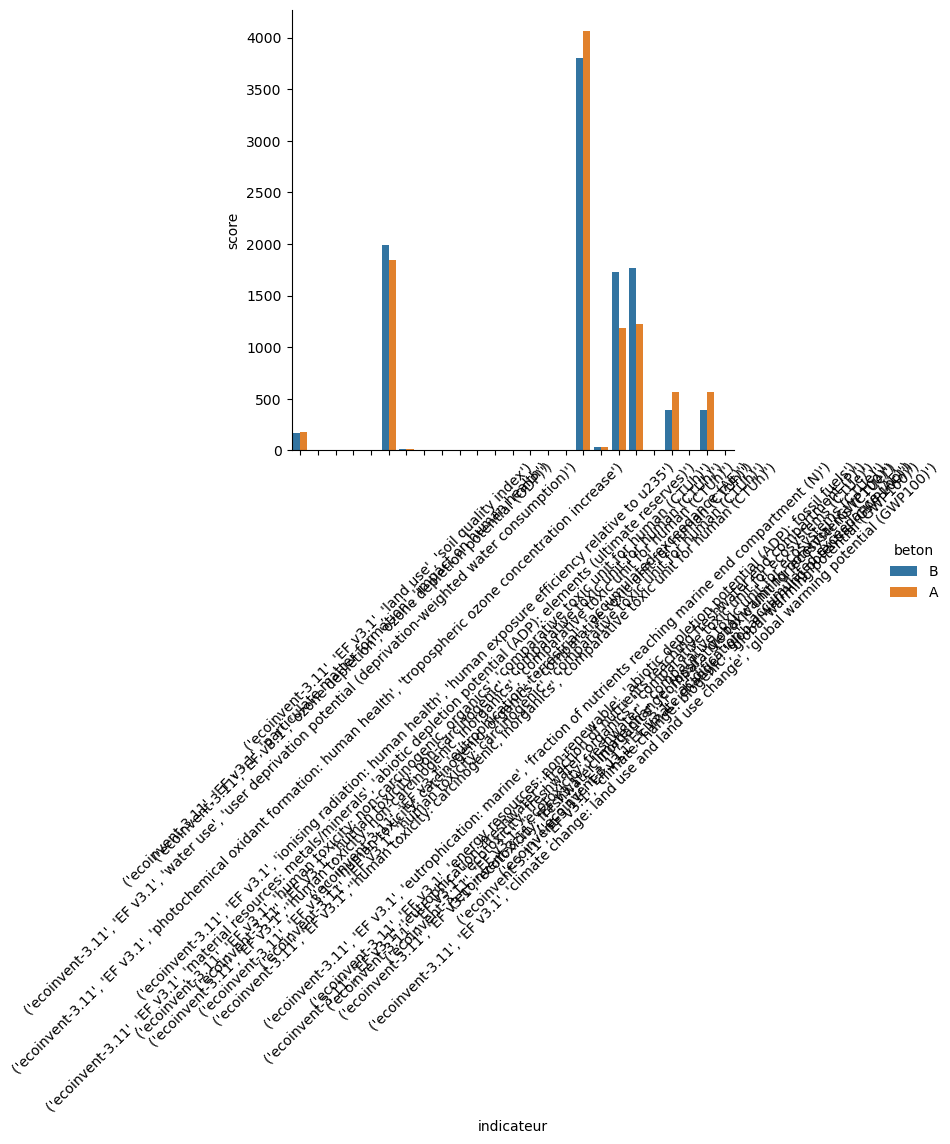

In [ ]:
import seaborn as sns
g=sns.catplot(data=res,x='indicateur',y='score',hue='beton',kind='bar')
g.set_xticklabels(rotation = 45)

In [95]:
import pandas as pd

df_impact =pd.read_excel('/home/thibault.chevilliet@enpc.fr/Documents/Cours ACV notebook/Cours 2025/impact_world_plus_2.1 (incl. CO2 uptake)_expert_version_ecoinvent_v311.xlsx')

In [ ]:
import Bw25_personal_functions as perso
indicators = perso.unique_list(p)
for row in pandas.index :



my_cf_data = [
    (biosphere_node_1, 42),
    (biosphere_node_1, 23, 'BR'),
    (biosphere_node_2, {
        'uncertainty_type': sa.TriangularUncertainty.id,
        'amount': 7,
        'loc': 7,
        'maximum': 21
    })
]
bd.Method(('<impact>', '<category>')).write(my_cf_data)

In [79]:
met = [m for m in bd.methods if 'water' in str(m)][0]
met

('ecoinvent-3.11',
 'CML v4.8 2016 no LT',
 'ecotoxicity: freshwater no LT',
 'freshwater aquatic ecotoxicity (FAETP inf) no LT')

In [ ]:
from polyviz import sankey

sankey(activity,met,level = 5)

Calculating supply chain score...
Sankey diagram generated.


('/home/thibault.chevilliet@enpc.fr/Documents/Cours ACV notebook/Cours 2025/anchovy capture by steel purse seiner and landing whole fresh kilogram ES ecoinvent311CML v48 2016 no LTecotoxicity freshwater no LTfreshwater aquatic ecotoxicity FAETP inf no LT sankey.html',
                                                source  \
 0   anchovy, capture by steel purse seiner and lan...   
 1                             activities below cutoff   
 2       m. for diesel, burned in fishing vessel (GLO)   
 3                        m. for lubricating oil (RER)   
 4        m. for purse seiner maintenance, steel (GLO)   
 ..                                                ...   
 62                m. for waste plastic, mixture (RoW)   
 63                    m. for waste polyethylene (RoW)   
 80                                          emissions   
 64                            activities below cutoff   
 81                                          emissions   
 
                                 

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/thibault.chevilliet@enpc.fr/snap/codium/common/.cache/gio-modules/libgiolibproxy.so
Gtk-Message: 14:42:45.356: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
Gtk-Message: 14:42:45.477: Failed to load module "canberra-gtk-module"
Gtk-Message: 14:42:45.480: Failed to load module "canberra-gtk-module"
